# Yolov6 theory and hands-on implementation
In this colab notebook the characteristics of the yolov6 convolutional neural network will be researched in order to obtain information and apply it. In this way, we will, as in the last YOLO models, analyze the backbone, the neck and the head and what are the improvement motivations in the case of the global model, which characteristics or different parts are being improved with its implementation and which state of the art technologies are being implemented. Also, for this YOLO network one of the main focus was to make it more applicable for industrial applications and the deployment on real-case studies, so a really important focus on the model deployment and, in this way, to quantization techniques for accelerating predictions.



*   Backbone: in this way, the presented model wanted to implement blocks which could improve the representation of the image. The state of the art blocks were two and were implemented separately with two different types of blocks, depending on the type of application.
  - If the objective is maximize accuracy with large models, the CSPStackRep blocks networks were used.
  - If the objective is to improved the time performance in smaller models the RepBlock networks were used.

*   Neck: PAN methos was used as were used in v5 and v4 improved with the representation of RepBlocks or CSPStackRep Blocks for building Rep-PAN (the improved PAN method)
*   Head: decoupled HEAD for improving the efficience of the network.

All this changes could be seen in the next image:

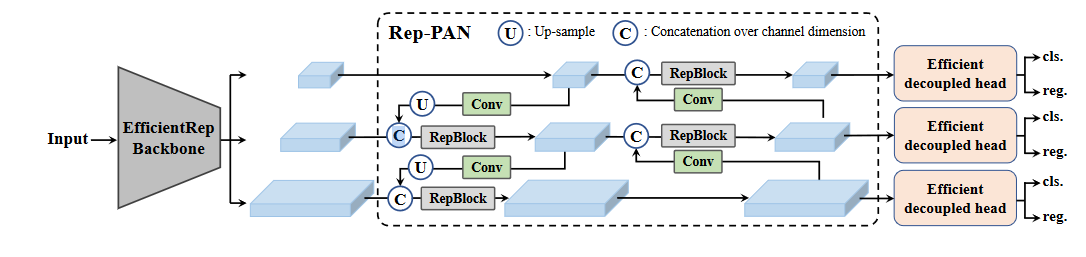




In the following image, the different blocks used in this image are break into its different parts in order to be able to implement them. In the image are also being explained, so we can implement it easily:




  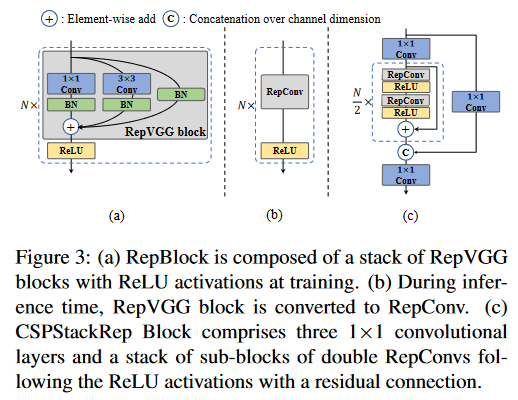

Some interesting other features of this model:
- RepOptimizer proposes gradient re-parameterization at
each optimization step. This technique also well solves
the quantization problem of reparameterization-based mod-
els. We hence reconstruct the re-parameterization blocks
of YOLOv6 in this fashion and train it with RepOptimizer
to obtain PTQ-friendly weights. The distribution of feature
map is largely narrowed (e.g. Fig. 4, more in B.1), which
greatly benefits the quantization process, see Sec 3.5.1 for
results
- We further improve the PTQ performance by partially con-
verting quantization-sensitive operations into float compu-
tation. To obtain the sensitivity distribution, several metrics
are commonly used, mean-square error (MSE), signal-noise
ratio (SNR) and cosine similarity. Typically for compari-
son, one can pick the output feature map (after the activa-
tion of a certain layer) to calculate these metrics with and
without quantization. As an alternative, it is also viable to
6 compute validation AP by switching quantization on and off
for the certain layer
- The added capability of QAT(Quantization-aware training) for improving the results of PTQ.

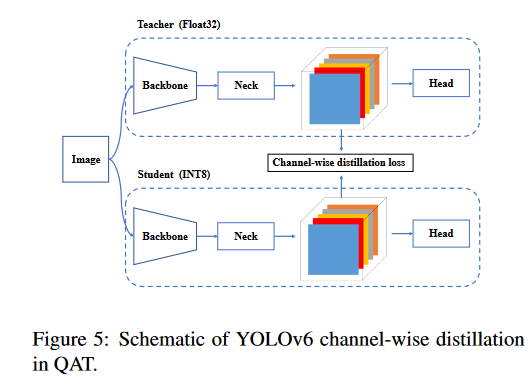

## Hands-on programming

We are going to try to replicate the model simplified with tensorflow. The original model is programmed in Pytorch but in this repository we are only trying to understand how models are built and try to replicate it similarly. This will help us to a deeper understand of deep learning and object detection using yolo.

### Construction blocks

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, Add, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, filters, kernel_size, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(x, filters):
    skip = x
    x = conv_block(x, filters // 2, 1)
    x = conv_block(x, filters, 3)
    x = Add()([skip, x])
    return x

def CSP_block(x, filters, num_blocks):
    x = conv_block(x, filters, 3, strides=2)
    route = conv_block(x, filters // 2, 1)
    x = conv_block(x, filters // 2, 1)
    for _ in range(num_blocks):
        x = residual_block(x, filters // 2)
    x = Conv2D(filters // 2, 1, padding='same')(x)
    x = Concatenate()([x, route])
    x = conv_block(x, filters, 1)
    return x


### Backbone

In [ ]:
def backbone(x):
    x = conv_block(x, 32, 3, strides=1)
    x = CSP_block(x, 64, 1)
    x = CSP_block(x, 128, 2)
    x = CSP_block(x, 256, 8)
    x = CSP_block(x, 512, 8)
    x = CSP_block(x, 1024, 4)
    return x

Neck (REP-PAN)

In [ ]:
def neck(x):
    # Implementación simplificada de Rep-PAN
    return x

### Head

In [ ]:
def head(x, num_classes):
    output_layers = []
    for filters in [256, 512, 1024]:
        x = conv_block(x, filters, 3)
        x = Conv2D(3 * (num_classes + 5), 1)(x)
        output_layers.append(x)
    return output_layers


### Complete model

In [ ]:
def yolov6(input_shape, num_classes):
    inputs = Input(input_shape)
    x = backbone(inputs)
    x = neck(x)
    outputs = head(x, num_classes)
    model = Model(inputs, outputs)
    return model

# Ejemplo de uso
model = yolov6((640, 640, 3), num_classes=80)
model.summary()